In [1]:
# 다른 경로에 있는 모듈을 가져오기 위해 절대 경로 추가

import os
import sys

root = os.path.join(os.path.abspath(os.getcwd()), '..', '..')
root = os.path.normpath(root)

if root not in sys.path:
    sys.path.insert(0, root)

In [2]:
# 필요한 라이브러리 로드

import emoji
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import torch
from communav.utils import db
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from soynlp.normalizer import repeat_normalize
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

/tmp/ipykernel_137163/2000937440.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# 카테고리 정의

CATEGORIES = {
    0: '자유',
    1: '학사',
    2: '장학 · 행정',
    3: '학교생활',
    4: '수업',
    5: '수업/이과',
    6: '수업/문과',
    7: '캠퍼스',
    8: '취업 · 진로',
    9: '일상생활',
    10: '음식점 · 카페',
    11: '취미 · 여가',
    12: '인간관계',
    13: '병역'
}

In [4]:
# 파라미터 설정

TABLE_NAME = 'everytime_article_dataset_v1'
MODEL_ID = '.model-iteration-64-epoch-12-0.9582'
TOKENIZER_ID = '.model-iteration-64-epoch-12-0.9582'
SEED = 42
USE_RANDOM_SEED = True
NUM_LABELS = len(CATEGORIES)
MAX_LENGTH = 128
METRIC_AVERAGE = 'weighted'
METRIC_ZERO_DIVISION = 0
BATCH_SIZE = 32
THRESHOLD = 0.5

In [5]:
# 랜덤 시드 고정

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

if not USE_RANDOM_SEED:
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if device.type == 'cuda':
        torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060 Ti


In [6]:
# 커뮤니티 게시글 데이터 로드

connection = db.get_connection()
cursor = connection.cursor()

cursor.execute(f'''
    SELECT * FROM {TABLE_NAME}
''')
original_articles = cursor.fetchall()
print(f'Loaded {len(original_articles)} articles.')

cursor.close()
db.close_connection()

Connected to DB successfully.
Loaded 299314 articles.


In [7]:
# 가져온 데이터의 일부를 출력

for article in original_articles[:20]:
    print(article)

{'id': 1, 'article_id': 21479637, 'title': '어제 비마관 화장실에서 핸드폰 찾아주신분!', 'text': '제가 경황이 없어서 감사하다고도 못 했네요.\n정말 감사합니다!!!', 'category_id': 9, 'is_verified': 1, 'possible_category_id': 9, 'probs_category_0': 0.0028829, 'probs_category_1': 0.00020712, 'probs_category_2': 0.000260727, 'probs_category_3': 6.46357e-05, 'probs_category_4': 4.84098e-05, 'probs_category_5': 9.69759e-06, 'probs_category_6': 4.07982e-05, 'probs_category_7': 0.000438644, 'probs_category_8': 8.59291e-05, 'probs_category_9': 0.994373, 'probs_category_10': 0.000606838, 'probs_category_11': 0.000401992, 'probs_category_12': 0.000305779, 'probs_category_13': 0.000273992}
{'id': 2, 'article_id': 21480514, 'title': '클럽좋아하시는분 계세요~?', 'text': '남자 신입생인데 주말에갈려하는데 같이가실분 괌', 'category_id': None, 'is_verified': None, 'possible_category_id': 11, 'probs_category_0': 0.000897024, 'probs_category_1': 0.000141423, 'probs_category_2': 1.96468e-05, 'probs_category_3': 0.000895898, 'probs_category_4': 0.00010174, 'probs_category_5': 0.0001

In [8]:
# 데이터 전처리 함수 정의

normal_pattern = re.compile(r'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣]+')
url_pattern = re.compile(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

def preprocess(value):
    value = normal_pattern.sub(' ', value)
    value = emoji.replace_emoji(value, replace='')
    value = url_pattern.sub('', value)
    value = repeat_normalize(value, num_repeats=2)
    value = value.strip()
    return value

In [9]:
# 데이터 전처리

contents = [preprocess(article['title'] + ' ' + article['text']) for article in tqdm(original_articles)]

100%|██████████| 299314/299314 [00:10<00:00, 29055.95it/s]


In [10]:
# 전처리된 데이터의 일부를 출력

for content in contents[:20]:
    print(content)

어제 비마관 화장실에서 핸드폰 찾아주신분! 제가 경황이 없어서 감사하다고도 못 했네요. 정말 감사합니다!!!
클럽좋아하시는분 계세요~? 남자 신입생인데 주말에갈려하는데 같이가실분 괌
조은문화사 몇시에 보통 열리나요?? 1교시 수업 책 찾아야되서
전공수업듣는데 복학한거처럼 보이는 형이 열심히는 하시던데 뭔가 군대갔다고오고 모든걸 까먹은 자기를 자책하듯이 수업듣는걸 보고 나도 3년후에 저러겠구나 싶더라... ㅠㅠ
정문에 있는 인쇄집들 몇시까지 하는지 아시나요? 9시 넘어야 갈수있을거 같은데 열어 있을지..
이런사람들 많나? 신입생 새터때 번호교환하고 학교서 인사만좀 하는사이였다가 연락 한 번도 안하고 군대가고 카톡친추는 되어있어서 누군지는 알고 복학하고 오니 서로 얼굴은아는데 인사하기도 민망하고 껄끄러운사이 너무 불편하다 엮일일 없으면 상관없는데 자꾸 마주치면 괜히 불편함
해상도! UHD 즉 4K면 코딩할때 글자 잘 안보이겠죠? 그냥 FHD면 충분?
문화유목시대 교재뭔가요 정정기간때 신청해서 잘 모르겠어요. ㅠㅠ 계획서보니까 고른다고하는데 뭐에요?
난 멋있어 멋있어
내일 공강이다 불기둥 같은 월화수를 마치고 목금이 오긴 왔네...
힙동 들어가고싶긴한데 커버밖에 못하고 리얼 힙찔이라 엄두가안난다
바람지원했는데요 아직 연락이 안왔는데 다들 안온건가요!?
전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;; 이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가? 왜 일자로만 나와....
전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;; 이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가? 왜 일자로만 나와.... 이건 회로인데 뭐가 잘못된거지요????;;
이쯤에서 질문 전공서적 (2 3 4학년 상관없음) 1. 새책산다 2. 중고로 산다 3. 제본뜬다 4. 물려받는다 새책사거나 중고사신분 또 질문 a. 중고로 판다 b. 그냥 가지고 있는다 c. 물려준다
화공과 유기화학1수업 책 : 스미스 유

In [11]:
# 토크나이저 로드

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_ID)

print('Original:', contents[0])
print('Tokenized:', tokenizer.tokenize(contents[0]))

Original: 어제 비마관 화장실에서 핸드폰 찾아주신분! 제가 경황이 없어서 감사하다고도 못 했네요. 정말 감사합니다!!!
Tokenized: ['어제', '비', '##마', '##관', '화장실', '##에서', '핸드폰', '찾아', '##주신', '##분', '!', '제가', '경', '##황', '##이', '없어서', '감사', '##하다고', '##도', '못', '했네요', '.', '정말', '감사합니다', '!', '!', '!']


In [12]:
# 모델 로드

model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=NUM_LABELS)
model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [13]:
# 모델 세부 정보 수정

model.resize_token_embeddings(len(tokenizer))

Embedding(54343, 768, padding_idx=0)

In [14]:
# 텍스트 인코딩 및 데이터셋 생성

encodings = tokenizer(
    contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
dataset = torch.utils.data.TensorDataset(
    torch.tensor(encodings['input_ids']),
    torch.tensor(encodings['attention_mask'])
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

/tmp/ipykernel_137163/3188963195.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(encodings['input_ids']),
/tmp/ipykernel_137163/3188963195.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(encodings['attention_mask'])


In [15]:
# 예측 수행

columns = [
    'id',
    'title',
    'text',
    'category_id',
    'possible_category_id',
    'predicted_category_id',
    *[f'probs_category_{i}' for i in range(NUM_LABELS)]
]
df_results = pd.DataFrame(original_articles, columns=columns)
df_results['category_id'] = df_results['category_id'].fillna(-1).astype(int)

for i, batch in enumerate(tqdm(dataloader, desc='Predicting')):
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        probabilities = torch.softmax(logits, dim=1)

    start_index = i * BATCH_SIZE
    end_index = start_index + BATCH_SIZE

    df_results.loc[start_index:end_index - 1, 'predicted_category_id'] = predictions.tolist()
    for j in range(NUM_LABELS):
        df_results.loc[start_index:end_index - 1, f'probs_category_{j}'] = probabilities[:, j].tolist()

df_results['predicted_category_id'] = df_results['predicted_category_id'].astype(int)

print('Prediction completed.')

Predicting: 100%|██████████| 9354/9354 [18:29<00:00,  8.43it/s]

Prediction completed.


In [16]:
# 예측 결과의 일부를 출력

df_results.head(20)

,id,title,text,category_id,possible_category_id,predicted_category_id,probs_category_0,probs_category_1,probs_category_2,probs_category_3,probs_category_4,probs_category_5,probs_category_6,probs_category_7,probs_category_8,probs_category_9,probs_category_10,probs_category_11,probs_category_12,probs_category_13
0,1,어제 비마관 화장실에서 핸드폰 찾아주신분!,제가 경황이 없어서 감사하다고도 못 했네요.\n정말 감사합니다!!!,9,9,9,0.000402,0.000042,0.000172,0.000935,0.000105,0.000064,0.000027,0.002770,0.000422,0.993802,0.000713,0.000102,0.000426,0.000018
1,2,클럽좋아하시는분 계세요~?,남자 신입생인데 주말에갈려하는데 같이가실분 괌,-1,11,11,0.001315,0.000199,0.000411,0.020121,0.000892,0.000532,0.000607,0.000539,0.001535,0.089414,0.004382,0.665849,0.213209,0.000994
2,3,조은문화사 몇시에 보통 열리나요??,1교시 수업 책 찾아야되서,7,7,7,0.000058,0.000073,0.000217,0.000512,0.000049,0.000188,0.000114,0.997310,0.000058,0.000183,0.001095,0.000056,0.000024,0.000061
3,4,전공수업듣는데,복학한거처럼 보이는 형이 열심히는 하시던데 뭔가 군대갔다고오고 모든걸 까먹은 자기를...,4,4,4,0.000145,0.001008,0.000088,0.001051,0.994564,0.001193,0.000408,0.000070,0.000892,0.000094,0.000035,0.000176,0.000218,0.000058
4,5,정문에 있는 인쇄집들 몇시까지 하는지 아시나요?,9시 넘어야 갈수있을거 같은데\n열어 있을지..,7,7,7,0.000058,0.000065,0.000179,0.000372,0.000043,0.000166,0.000088,0.997247,0.000062,0.000265,0.001332,0.000047,0.000022,0.000054
5,6,이런사람들 많나?,신입생 새터때 번호교환하고 학교서 인사만좀 하는사이였다가 연락 한 번도 안하고 군대...,-1,13,3,0.000262,0.000028,0.000298,0.992901,0.000673,0.000036,0.000106,0.000487,0.000206,0.002548,0.000098,0.001621,0.000703,0.000032
6,7,해상도!,UHD 즉 4K면 코딩할때 글자 잘 안보이겠죠?\n그냥 FHD면 충분?,-1,9,9,0.003065,0.001443,0.000989,0.001187,0.002339,0.000502,0.000106,0.001436,0.003643,0.982826,0.000975,0.000162,0.001243,0.000082
7,8,문화유목시대 교재뭔가요,정정기간때 신청해서 잘 모르겠어요. ㅠㅠ 계획서보니까 고른다고하는데 뭐에요?,6,6,6,0.000327,0.000101,0.000119,0.000305,0.000189,0.000508,0.997328,0.000436,0.000127,0.000024,0.000147,0.000318,0.000023,0.000049
8,9,난,멋있어 멋있어,-1,0,11,0.139631,0.000329,0.000337,0.017059,0.001653,0.001403,0.006289,0.000544,0.001067,0.001770,0.001943,0.806714,0.019629,0.001632
9,10,내일 공강이다,불기둥 같은 월화수를 마치고 목금이 오긴 왔네...,-1,3,3,0.000615,0.000207,0.000422,0.901717,0.078381,0.000840,0.007140,0.000735,0.001298,0.000752,0.000150,0.006961,0.000679,0.000102


In [17]:
# 평가 지표 계산 함수 정의

def calculate_metrics(true_labels, predicted_labels):
    acc = accuracy_score(true_labels, predicted_labels)
    prec = precision_score(true_labels, predicted_labels, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)
    rec = recall_score(true_labels, predicted_labels, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)
    f1 = f1_score(true_labels, predicted_labels, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)

    return acc, prec, rec, f1

In [18]:
# 평가 지표 출력

labels = []
predictions = []

for i in range(len(df_results)):
    if df_results.loc[i, 'category_id'] != -1:
        labels.append(df_results.loc[i, 'category_id'])
        predictions.append(df_results.loc[i, 'predicted_category_id'])

acc, prec, rec, f1 = calculate_metrics(labels, predictions)

print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9915
Precision: 0.9915
Recall: 0.9915
F1 Score: 0.9914


자유 (0): 37886 (12.66%)
학사 (1): 15188 (5.07%)
장학 · 행정 (2): 11084 (3.70%)
학교생활 (3): 18009 (6.02%)
수업 (4): 31005 (10.36%)
수업/이과 (5): 34418 (11.50%)
수업/문과 (6): 32802 (10.96%)
캠퍼스 (7): 25827 (8.63%)
취업 · 진로 (8): 13981 (4.67%)
일상생활 (9): 27506 (9.19%)
음식점 · 카페 (10): 6725 (2.25%)
취미 · 여가 (11): 20075 (6.71%)
인간관계 (12): 9805 (3.28%)
병역 (13): 5657 (1.89%)


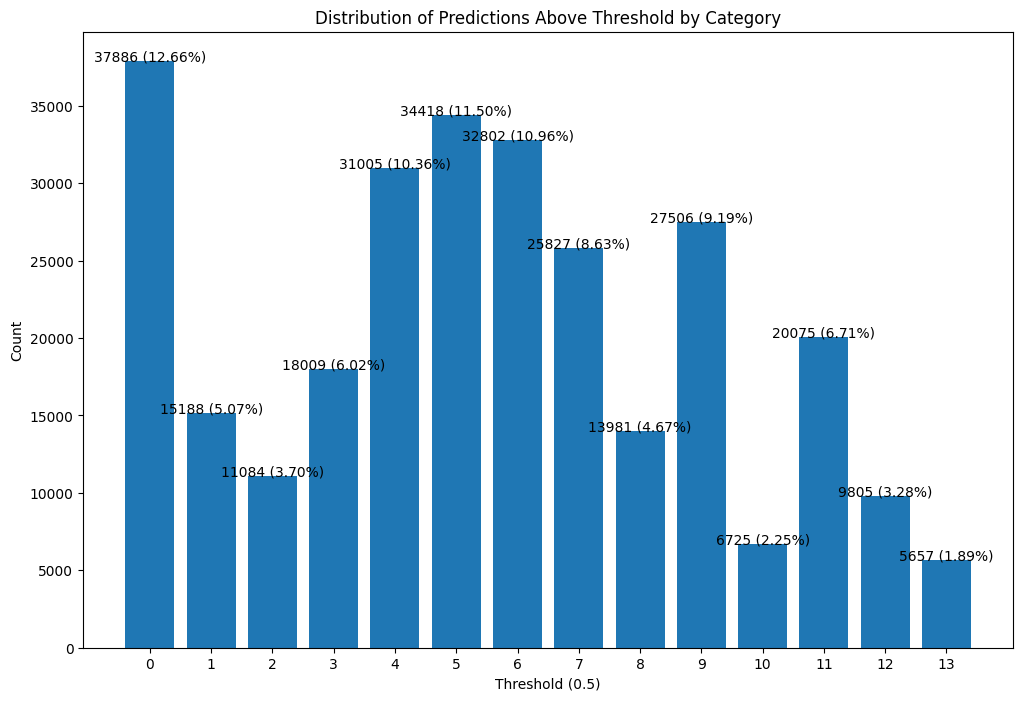

In [19]:
# 예측 결과의 비율을 출력

threshold_counts = [0] * NUM_LABELS
total_count = len(df_results)

for i in range(NUM_LABELS):
    column_name = f'probs_category_{i}'
    threshold_counts[i] = (df_results[column_name] > THRESHOLD).sum()

threshold_percentages = [(count / total_count * 100) for count in threshold_counts]

for i in range(NUM_LABELS):
    print(f'{CATEGORIES[i]} ({i}): {threshold_counts[i]} ({threshold_percentages[i]:.2f}%)')

plt.figure(figsize=(12, 8))
plt.bar(range(NUM_LABELS), threshold_counts)
for i, count in enumerate(threshold_counts):
    plt.text(i, count + 0.1, f'{count} ({threshold_percentages[i]:.2f}%)', ha='center')
plt.xlabel(f'Threshold ({THRESHOLD})')
plt.ylabel('Count')
plt.xticks(range(NUM_LABELS))
plt.title('Distribution of Predictions Above Threshold by Category')
plt.show()

Total changed count: 83554 (27.92%)
자유 [0]: 12025 (4.02%)
학사 [1]: 10314 (3.45%)
장학 · 행정 [2]: 3344 (1.12%)
학교생활 [3]: 4679 (1.56%)
수업 [4]: 10746 (3.59%)
수업/이과 [5]: 12469 (4.17%)
수업/문과 [6]: 2395 (0.80%)
캠퍼스 [7]: 3383 (1.13%)
취업 · 진로 [8]: 4884 (1.63%)
일상생활 [9]: 10241 (3.42%)
음식점 · 카페 [10]: 444 (0.15%)
취미 · 여가 [11]: 5598 (1.87%)
인간관계 [12]: 1918 (0.64%)
병역 [13]: 1114 (0.37%)


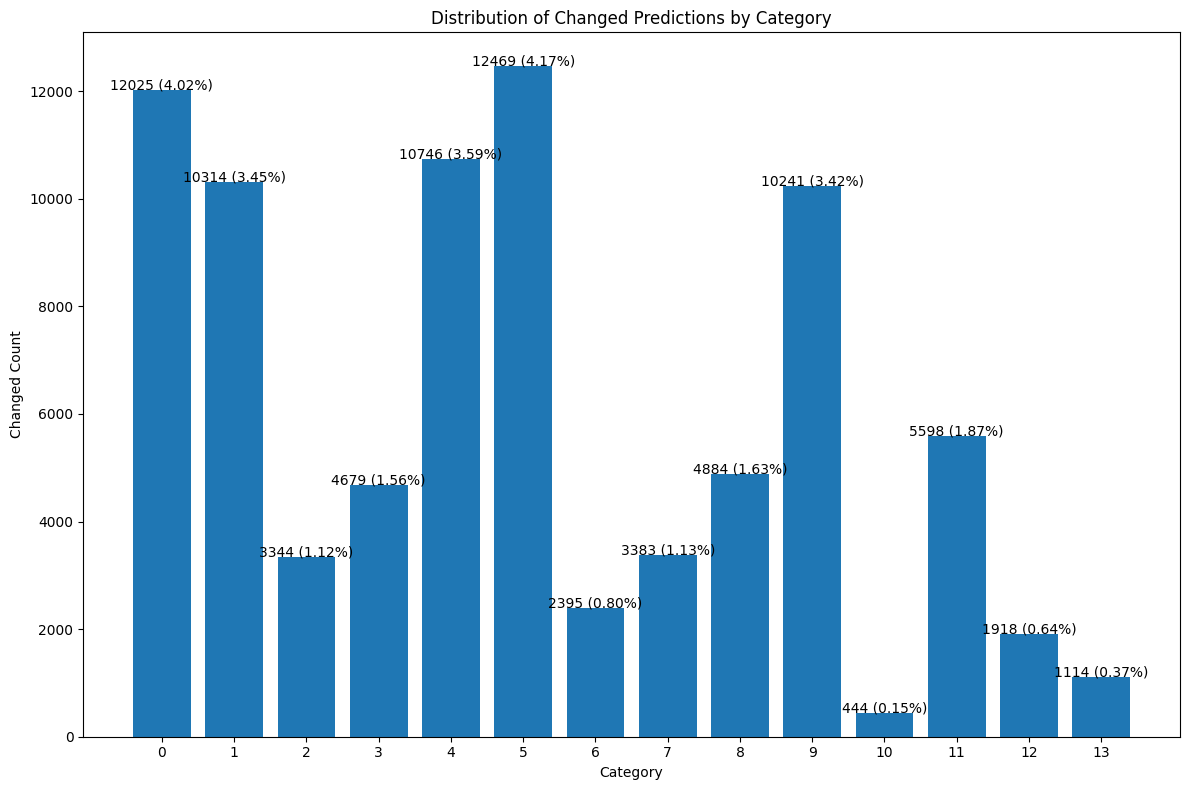

In [20]:
# 기존 카테고리와 예측 카테고리가 다른 경우의 비율을 출력

changed_counts = [0] * NUM_LABELS
total_count = len(df_results)

for i in range(total_count):
    possible_category_id = df_results.loc[i, 'possible_category_id']
    predicted_category_id = df_results.loc[i, 'predicted_category_id']
    if possible_category_id != predicted_category_id:
        changed_counts[possible_category_id] += 1

changed_percentages = [(count / total_count * 100) for count in changed_counts]
total_changed_count = sum(changed_counts)
total_changed_percentage = total_changed_count / total_count * 100

print(f'Total changed count: {total_changed_count} ({total_changed_percentage:.2f}%)')
for i in range(NUM_LABELS):
    print(f'{CATEGORIES[i]} [{i}]: {changed_counts[i]} ({changed_percentages[i]:.2f}%)')

plt.figure(figsize=(12, 8))
plt.bar(range(NUM_LABELS), changed_counts)
for i, count in enumerate(changed_counts):
    plt.text(i, count + 0.1, f'{count} ({changed_percentages[i]:.2f}%)', ha='center')
plt.xlabel('Category')
plt.ylabel('Changed Count')
plt.xticks(range(NUM_LABELS))
plt.title('Distribution of Changed Predictions by Category')
plt.tight_layout()
plt.show()

In [21]:
# 예측 결과를 DB에 저장

connection = db.get_connection()
cursor = connection.cursor()

sql_template = f'''
    INSERT INTO {TABLE_NAME} (id, possible_category_id, {{columns}})
    VALUES (%s, %s, {{placeholders}})
    ON DUPLICATE KEY UPDATE
        possible_category_id = VALUES(possible_category_id),
        {{updates}}
'''

columns = ', '.join([f'probs_category_{i}' for i in range(NUM_LABELS)])
placeholders = ', '.join(['%s' for _ in range(NUM_LABELS)])
updates = ', '.join([f'probs_category_{i} = VALUES(probs_category_{i})' for i in range(NUM_LABELS)])

sql = sql_template.format(columns=columns, placeholders=placeholders, updates=updates)
values = [(row['id'], row['predicted_category_id'],) + tuple(row[f'probs_category_{i}'] for i in range(NUM_LABELS)) for _, row in df_results.iterrows()]

cursor.executemany(sql, values)
connection.commit()

cursor.close()
db.close_connection()

Connected to DB successfully.
